In [13]:
!curl -o test_set.zip https://zenodo.org/records/1327317/files/test_set.zip?download=1 -o test_set_pixel_size.csv https://zenodo.org/records/1327317/files/test_set_pixel_size.csv?download=1 -o training_set.zip https://zenodo.org/records/1327317/files/training_set.zip?download=1 -o training_set_pixel_size_and_HC.csv https://zenodo.org/records/1327317/files/training_set_pixel_size_and_HC.csv?download=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.5M  100 41.5M    0     0  81.2M      0 --:--:-- --:--:-- --:--:-- 81.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9096  100  9096    0     0  62400      0 --:--:-- --:--:-- --:--:-- 62731
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126M  100  126M    0     0   102M      0  0:00:01  0:00:01 --:--:--  102M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33688  100 33688    0     0   223k      0 --:--:-- --:--:-- --:--:--  225k


In [2]:
# importing the zipfile module 
from zipfile import ZipFile 

# loading the temp.zip and creating a zip object 
with ZipFile("/kaggle/working/training_set.zip", 'r') as zObject:  
    zObject.extractall( 
        path="/kaggle/working/") 
with ZipFile("/kaggle/working/test_set.zip", 'r') as zObject:  
    zObject.extractall( 
        path="/kaggle/working/") 


In [1]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

class UltrasoundDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        # Input image of model: all images in img_dir not containing "Annotation" in name
        # Output image of model: all images in img_dir containing "Annotation" in name
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = sorted([x for x in os.listdir(img_dir) if "Annotation" not in x])
        self.masks = sorted([x for x in os.listdir(img_dir) if "Annotation" in x])

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.img_dir, self.masks[idx])
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask



In [46]:
train_dataset.imgs[:10]

['000_HC.png',
 '001_HC.png',
 '002_HC.png',
 '003_HC.png',
 '004_HC.png',
 '005_HC.png',
 '006_HC.png',
 '007_HC.png',
 '008_HC.png',
 '009_HC.png']

In [47]:
train_dataset.masks[:10]

['000_HC_Annotation.png',
 '001_HC_Annotation.png',
 '002_HC_Annotation.png',
 '003_HC_Annotation.png',
 '004_HC_Annotation.png',
 '005_HC_Annotation.png',
 '006_HC_Annotation.png',
 '007_HC_Annotation.png',
 '008_HC_Annotation.png',
 '009_HC_Annotation.png']

In [19]:
# Define the transformation (3 channels to 1 channel)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()])
# Create the dataset
train_dataset = UltrasoundDataset(img_dir="training_set/training_set", transform=transform)
# 80% of the data will be used for training, 10% for validation, and 10% for testing
# Create the indices
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
split = int(np.floor(0.1 * dataset_size))
train_indices, val_indices, test_indices = indices[split*2:], indices[:split], indices[split:split*2]
# Create the samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, sampler=test_sampler)

In [74]:
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, sampler=test_sampler)

In [4]:
!pip install torch-summary

In [20]:
import torch
import torch.nn as nn
import torchsummary
from scipy.ndimage import gaussian_filter

def sharpen_predictions(predictions, sigma=1.0):
    blurred = gaussian_filter(predictions, sigma)
    sharper = predictions + predictions - blurred
    return sharper

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
        self.dconv_down5 = double_conv(512, 1024)
        self.dconv_down6 = double_conv(1024, 2048)       
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up5 = double_conv(1024 + 2048, 1024)
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)

        x = self.dconv_down6(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv5], dim=1)

        x = self.dconv_up5(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out
    
# Summary of the model
model = UNet(n_class=1)
torchsummary.summary(model, (1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        640
|    └─ReLU: 2-2                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-3                       [-1, 64, 256, 256]        36,928
|    └─ReLU: 2-4                         [-1, 64, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Sequential: 1-3                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-5                       [-1, 128, 128, 128]       73,856
|    └─ReLU: 2-6                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       147,584
|    └─ReLU: 2-8                         [-1, 128, 128, 128]       --
├─MaxPool2d: 1-4                         [-1, 128, 64, 64]         --
├─Sequential: 1-5                        [-1, 256, 64, 64]         --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        640
|    └─ReLU: 2-2                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-3                       [-1, 64, 256, 256]        36,928
|    └─ReLU: 2-4                         [-1, 64, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Sequential: 1-3                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-5                       [-1, 128, 128, 128]       73,856
|    └─ReLU: 2-6                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       147,584
|    └─ReLU: 2-8                         [-1, 128, 128, 128]       --
├─MaxPool2d: 1-4                         [-1, 128, 64, 64]         --
├─Sequential: 1-5                        [-1, 256, 64, 64]         --
|

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
# Loss function: Binary Cross Entropy
criterion = nn.BCEWithLogitsLoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
from tqdm import tqdm

# Use MAE as the metric to evaluate the model

def train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10):
    loss_train = []
    loss_valid = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        
        loss_train.append(running_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss/len(train_loader)}")
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            loss_valid.append(running_loss/len(valid_loader))
            print(f"Validation Loss: {running_loss/len(valid_loader)}")
    return loss_train, loss_valid

loss_train, loss_valid = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=10)

100%|██████████| 201/201 [00:43<00:00,  4.60it/s]


Epoch 1/10 - Loss: 1.4147262615869887
Validation Loss: 0.037038667127490044


100%|██████████| 201/201 [00:43<00:00,  4.62it/s]


Epoch 2/10 - Loss: 0.036056291682654944
Validation Loss: 0.034084132984280584


100%|██████████| 201/201 [00:43<00:00,  4.58it/s]


Epoch 3/10 - Loss: 0.033715769444680334
Validation Loss: 0.03254321224987507


100%|██████████| 201/201 [00:43<00:00,  4.61it/s]


Epoch 4/10 - Loss: 0.030633102527898342
Validation Loss: 0.029150136932730674


100%|██████████| 201/201 [00:43<00:00,  4.59it/s]


Epoch 5/10 - Loss: 0.027756066047656004
Validation Loss: 0.027044757306575774


100%|██████████| 201/201 [00:43<00:00,  4.60it/s]


Epoch 6/10 - Loss: 0.02648771744202915
Validation Loss: 0.02581461697816849


100%|██████████| 201/201 [00:43<00:00,  4.59it/s]


Epoch 7/10 - Loss: 0.025771070781409444
Validation Loss: 0.025299747735261918


100%|██████████| 201/201 [00:43<00:00,  4.60it/s]


Epoch 8/10 - Loss: 0.02534044182752792
Validation Loss: 0.02512346886098385


100%|██████████| 201/201 [00:43<00:00,  4.60it/s]


Epoch 9/10 - Loss: 0.0248738835422109
Validation Loss: 0.02488595128059387


100%|██████████| 201/201 [00:43<00:00,  4.59it/s]


Epoch 10/10 - Loss: 0.02442646767035942
Validation Loss: 0.025429679974913598


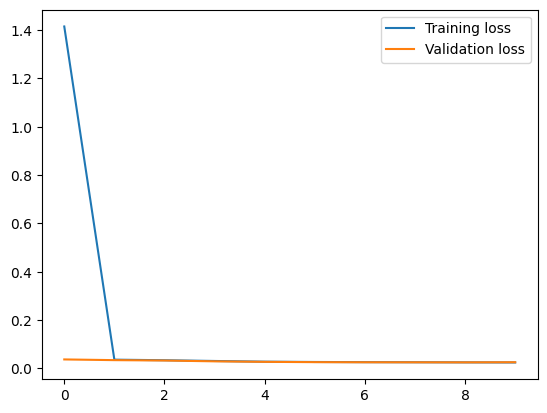

In [23]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'model.pth')


In [27]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")


Mean Absolute Error: 33.949249267578125
IoU: 0.022345803000710228


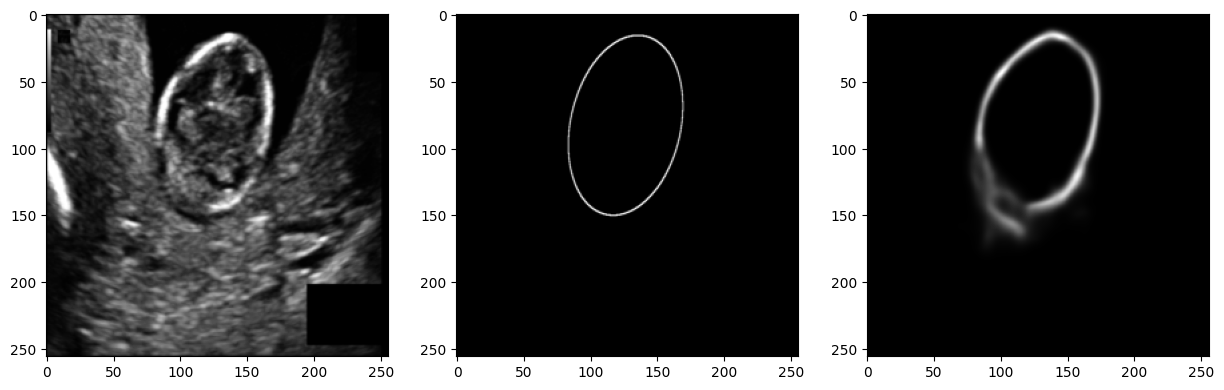

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


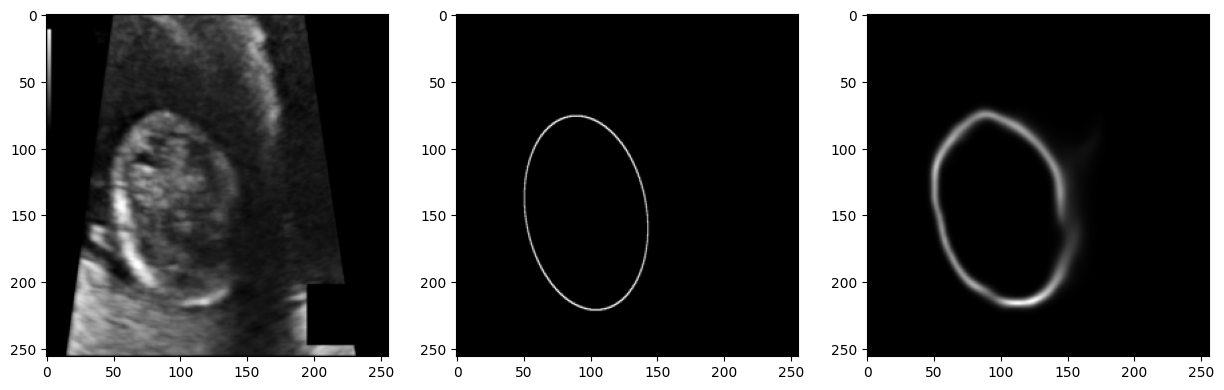

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


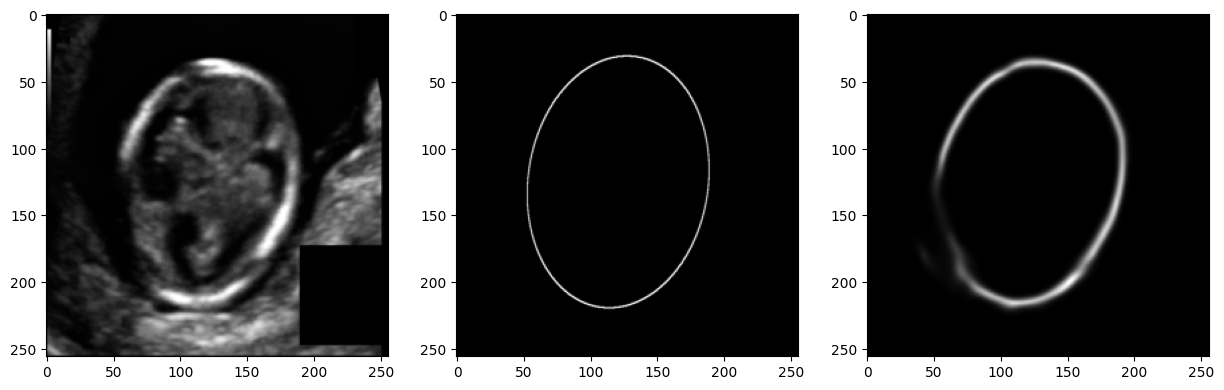

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


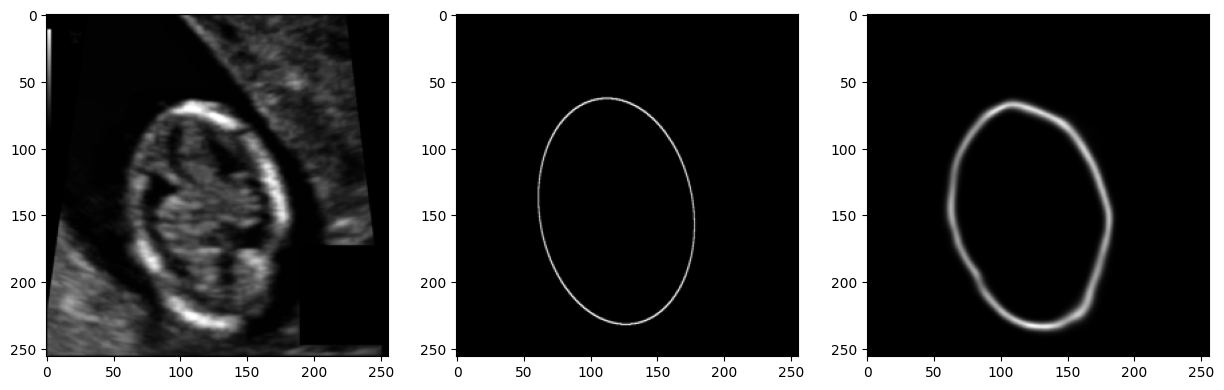

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


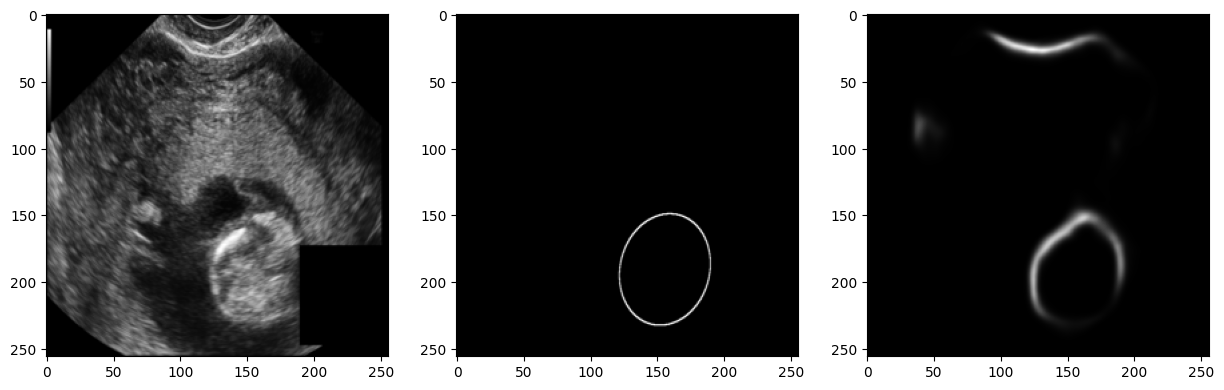

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


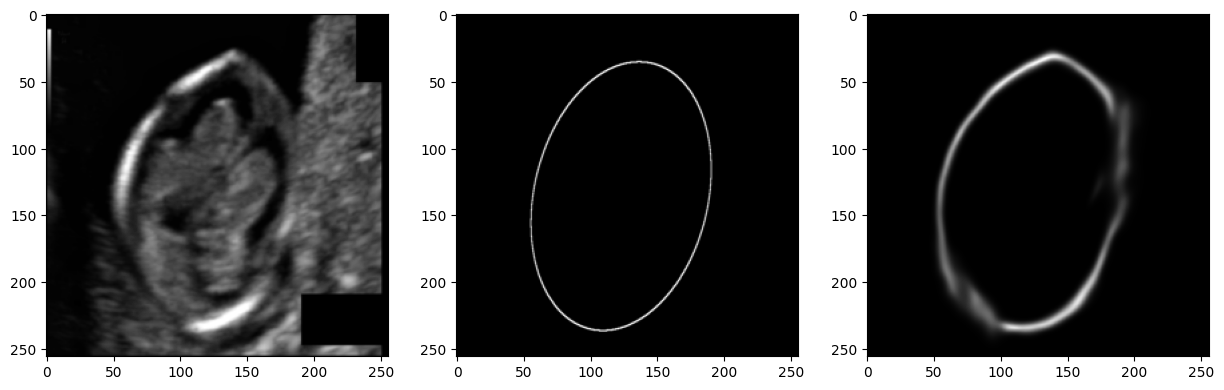

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


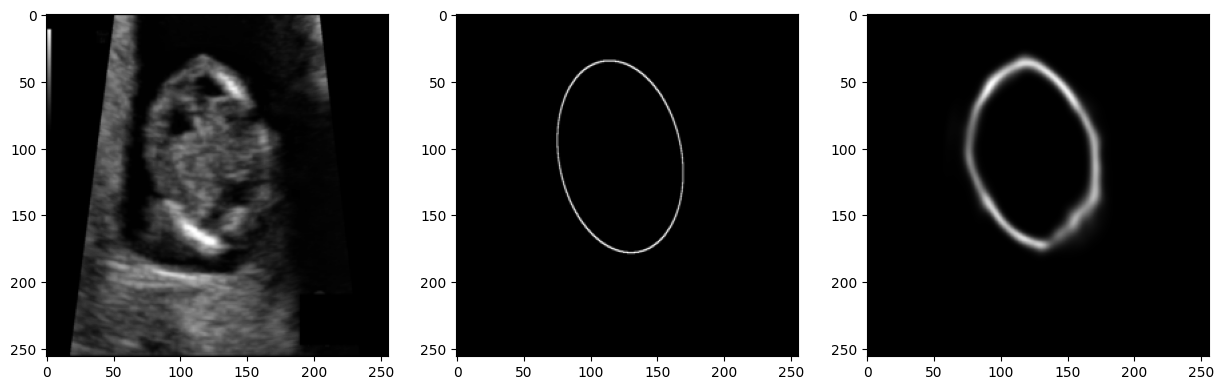

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


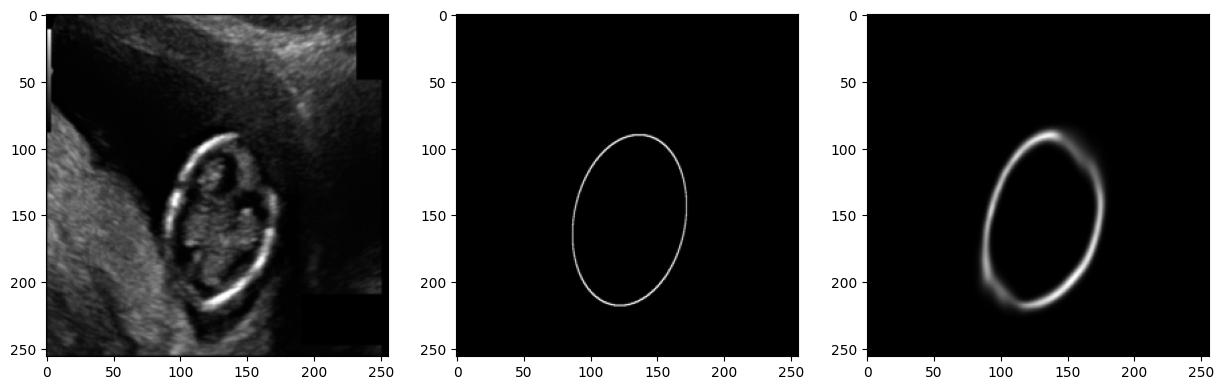

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


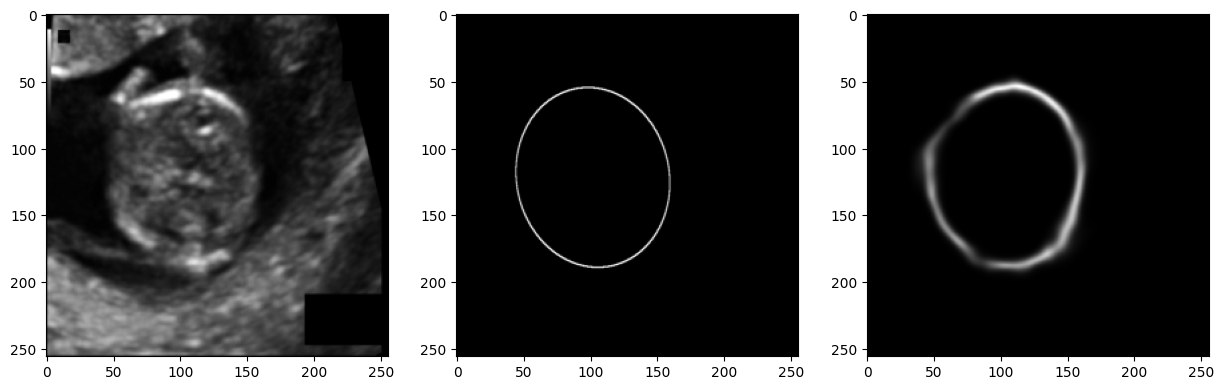

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


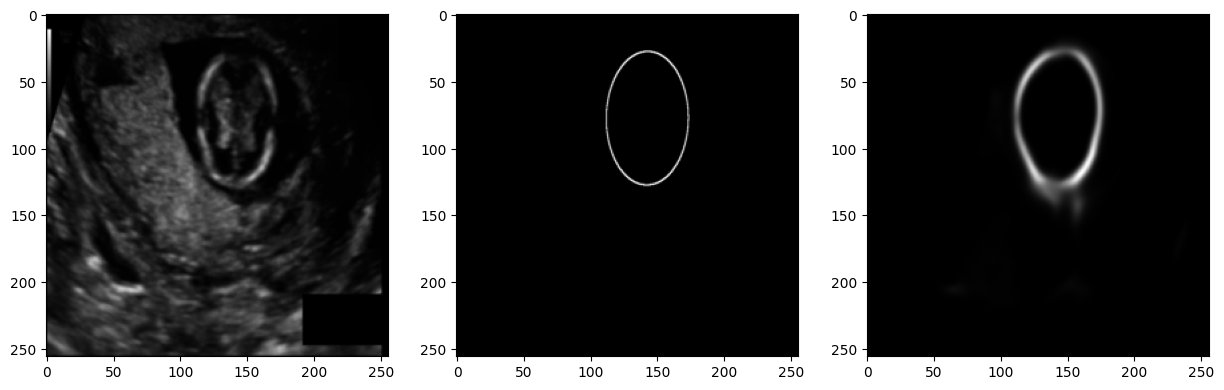

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
image_idx = 10
for image_idx in range(50, 60):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model(image.cuda().unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [44]:

class IoULoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(IoULoss, self).__init__()
        self.eps = eps

    def forward(self, inputs, targets):
        # Compute intersection
        intersection = (inputs * targets).sum()
        # Compute union
        total = (inputs + targets).sum()
        union = total - intersection 

        iou = (intersection + self.eps) / (union + self.eps)
        return 1 - iou
    
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.iou = IoULoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.iou(inputs, targets)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
# Now use IoU as the loss function
criterion = CombinedLoss()
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_train, loss_valid = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=10)

100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 1/10 - Loss: 0.6234162776031305
Validation Loss: 1.0352197432518004


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


Epoch 2/10 - Loss: 0.2353799647063165
Validation Loss: 0.22814354360103606


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 3/10 - Loss: 0.2273186322913241
Validation Loss: 0.22609594881534575


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 4/10 - Loss: 0.2257502390377557
Validation Loss: 0.22644725263118745


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 5/10 - Loss: 0.22442099518740355
Validation Loss: 0.2243256950378418


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 6/10 - Loss: 0.2224866727839655
Validation Loss: 0.22150570690631866


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 7/10 - Loss: 0.22074599067370096
Validation Loss: 0.22009569942951202


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 8/10 - Loss: 0.2200735481965601
Validation Loss: 0.2198583036661148


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 9/10 - Loss: 0.2195479052132042
Validation Loss: 0.21986754477024079


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


Epoch 10/10 - Loss: 0.21932447987112832
Validation Loss: 0.21952269911766054


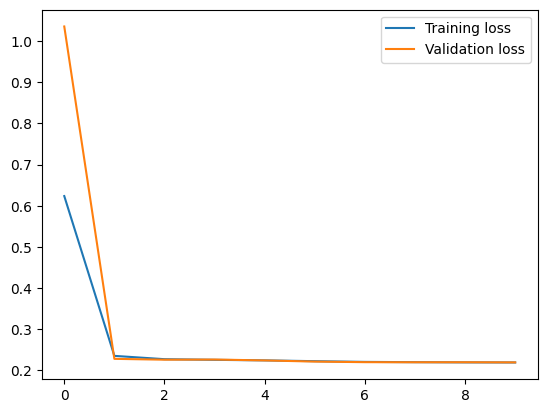

In [45]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'model.pth')


In [46]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")


Mean Absolute Error: 9.068881034851074
IoU: 0.022345803000710228


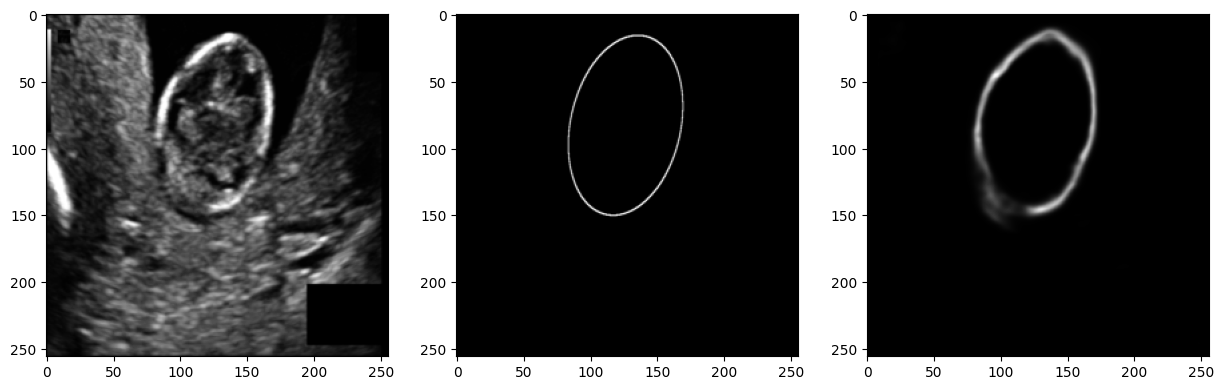

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


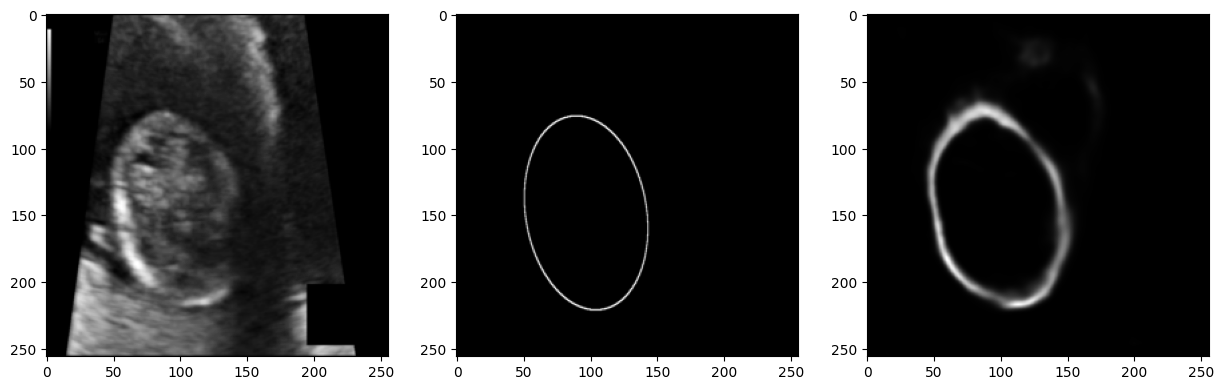

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


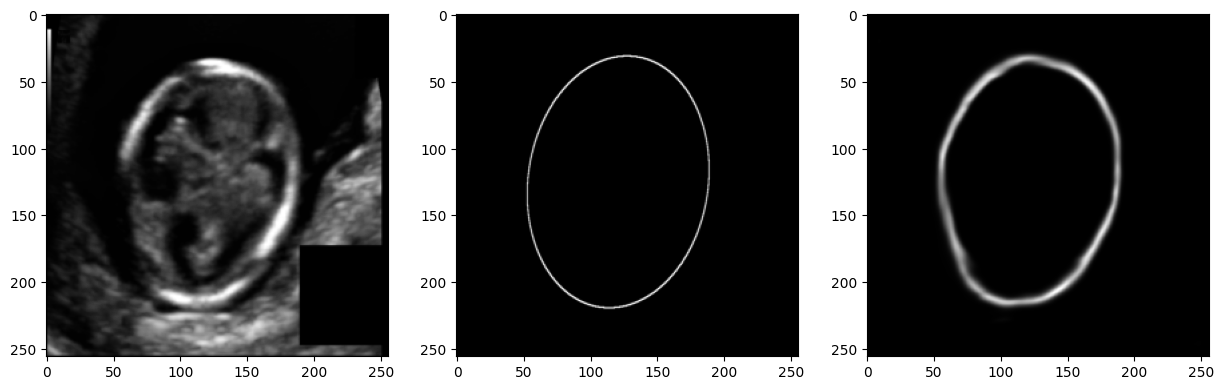

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


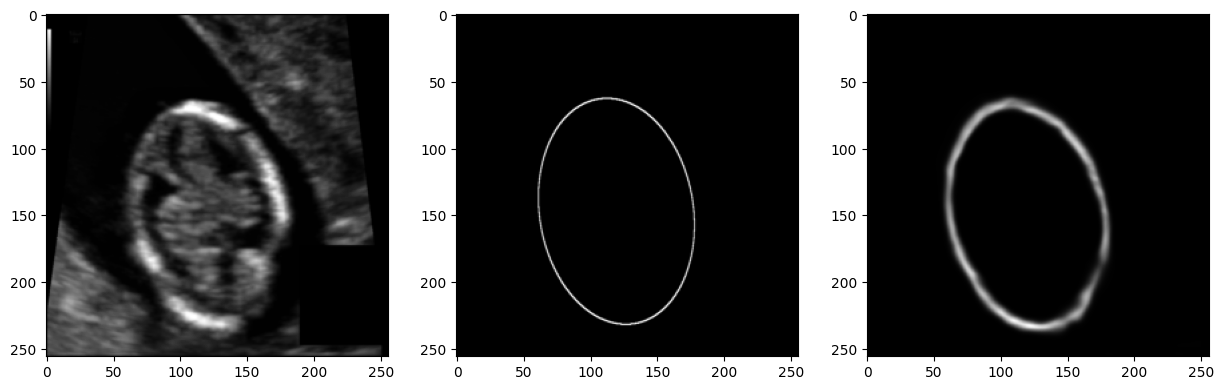

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


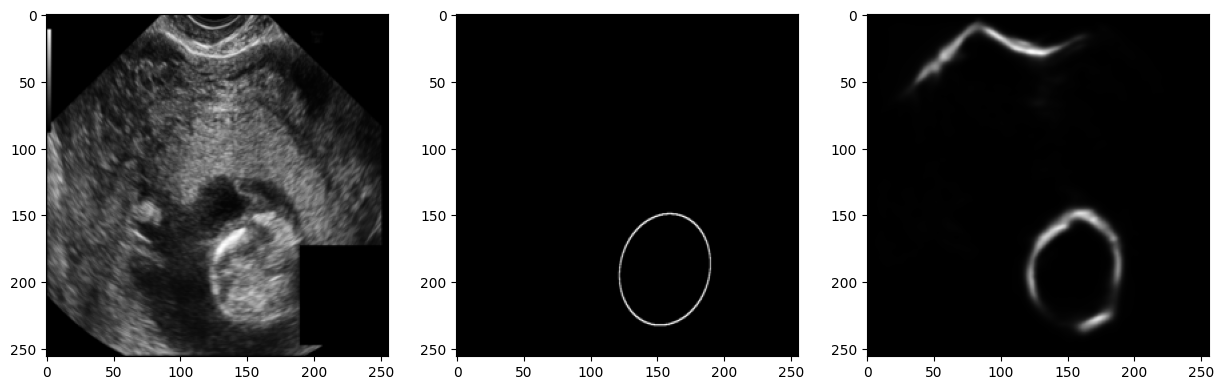

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


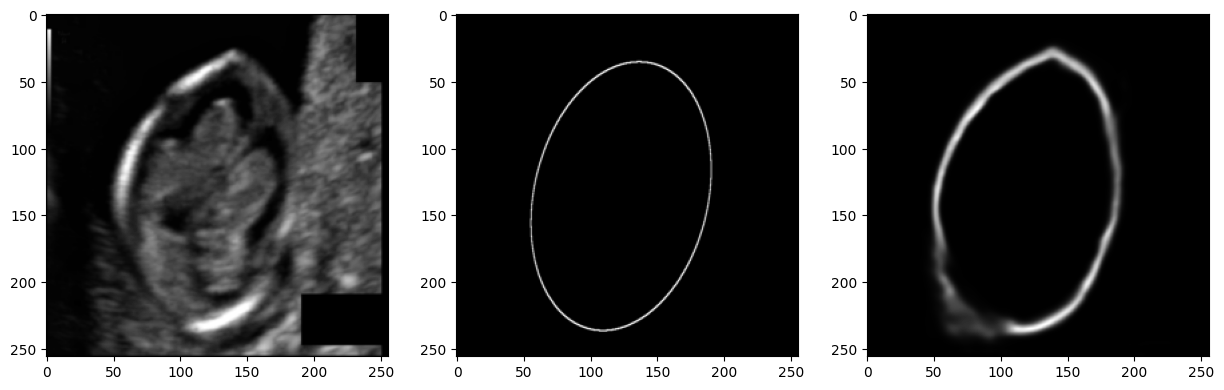

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


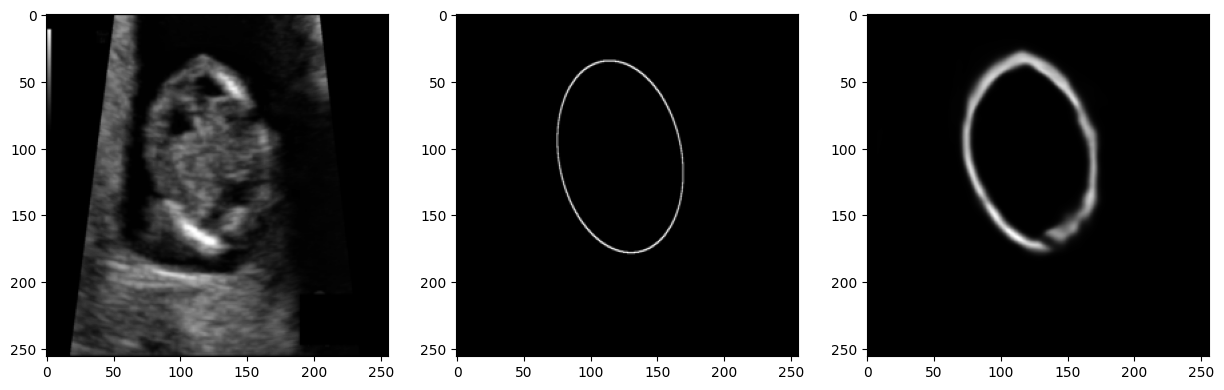

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


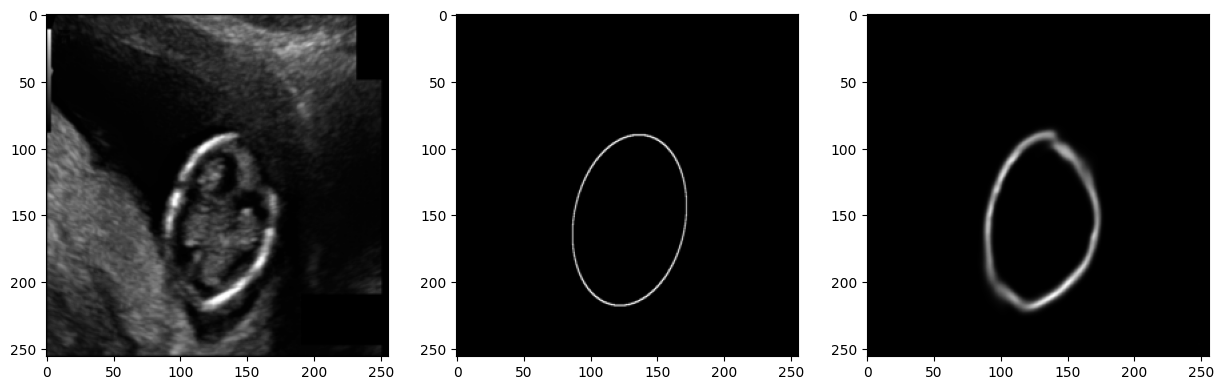

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


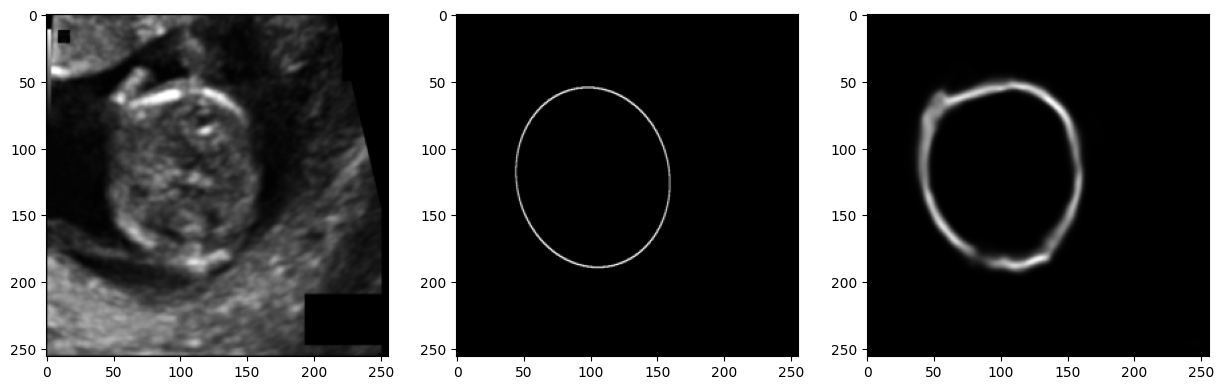

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


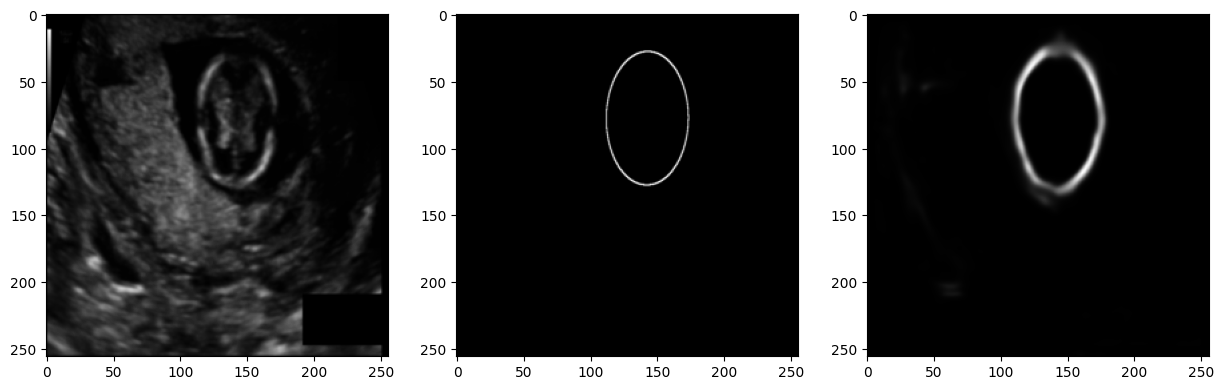

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [47]:
image_idx = 10
for image_idx in range(50, 60):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model(image.cuda().unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
# Now use IoU as the loss function
criterion = CombinedLoss(alpha=0.75)
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_train, loss_valid = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=10)

100%|██████████| 201/201 [00:45<00:00,  4.44it/s]


Epoch 1/10 - Loss: 3.9198467070190466
Validation Loss: 0.27671003103256225


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 2/10 - Loss: 0.27653671689887543
Validation Loss: 0.2758538591861725


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 3/10 - Loss: 0.2756460227479982
Validation Loss: 0.279226655960083


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 4/10 - Loss: 0.27505116009000524
Validation Loss: 0.2739163088798523


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 5/10 - Loss: 0.2736755873433393
Validation Loss: 0.2729864358901978


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 6/10 - Loss: 0.2726440926392873
Validation Loss: 0.2713313126564026


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 7/10 - Loss: 0.2705373624664041
Validation Loss: 0.2698946857452393


100%|██████████| 201/201 [00:45<00:00,  4.44it/s]


Epoch 8/10 - Loss: 0.2695218302420716
Validation Loss: 0.2695318150520325


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 9/10 - Loss: 0.2690536105514166
Validation Loss: 0.2690857815742493


100%|██████████| 201/201 [00:45<00:00,  4.44it/s]


Epoch 10/10 - Loss: 0.26877683860745594
Validation Loss: 0.26931887984275815


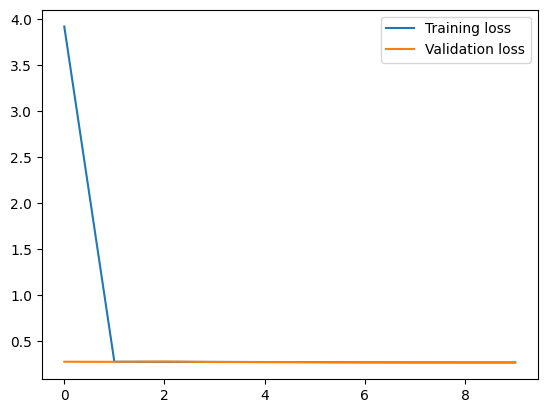

In [53]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'model.pth')


In [54]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")


Mean Absolute Error: 7.8377814292907715
IoU: 0.022345803000710228


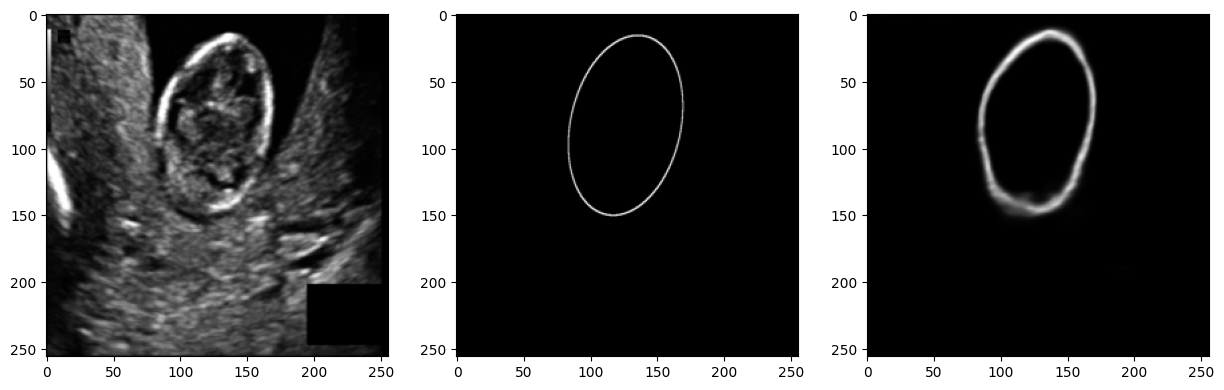

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


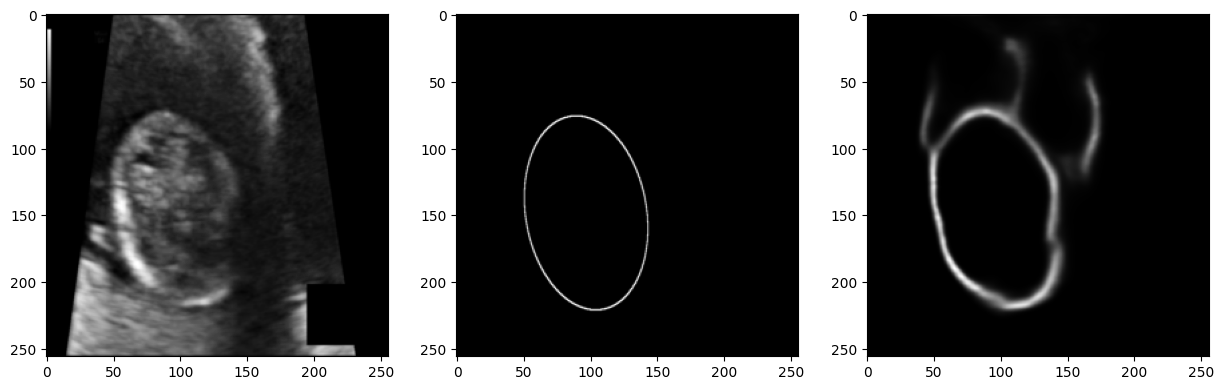

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


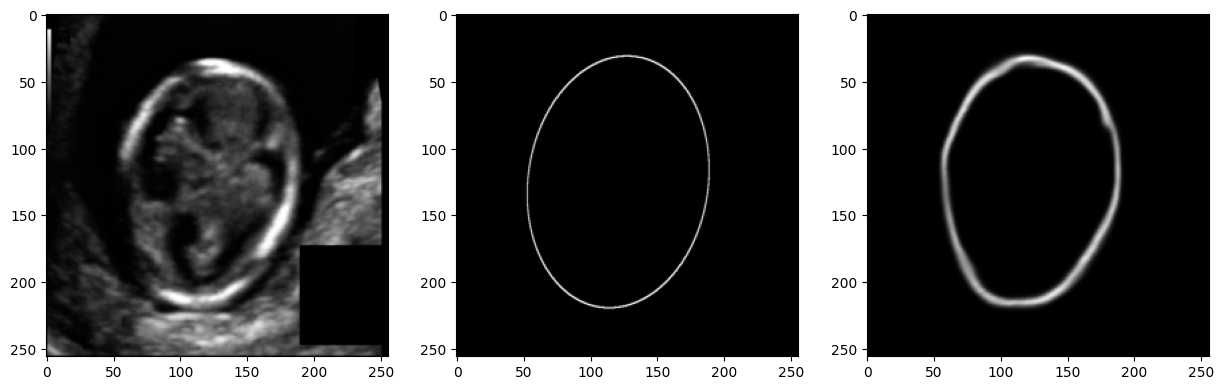

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


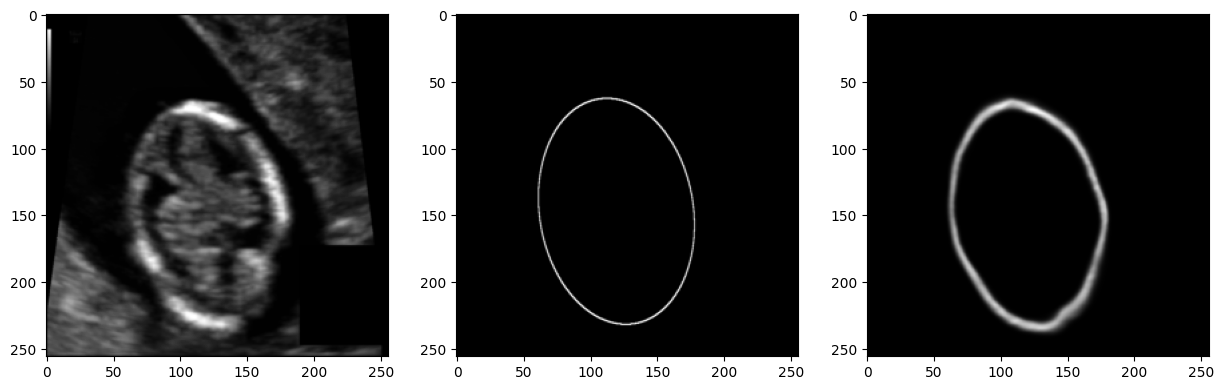

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


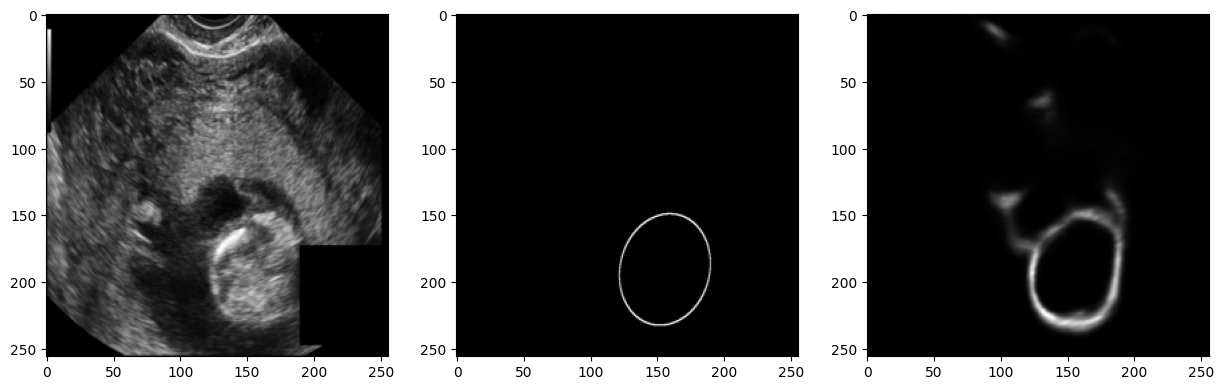

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


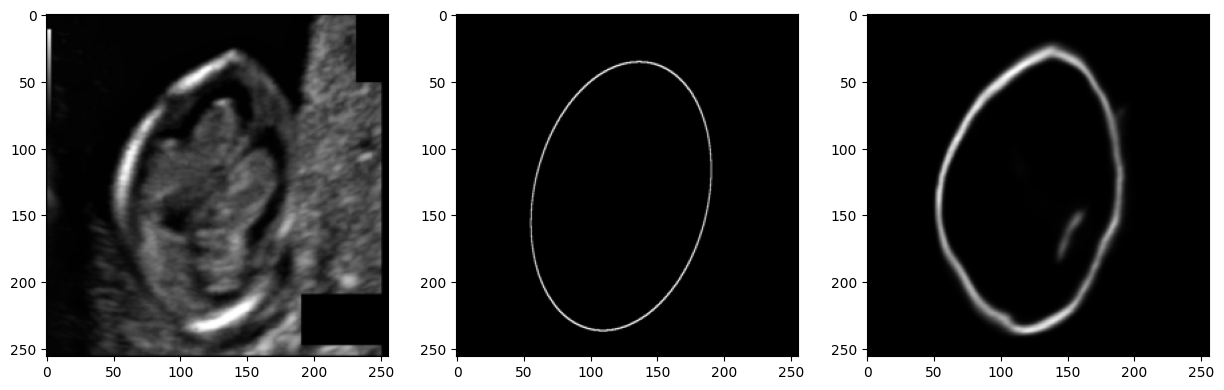

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


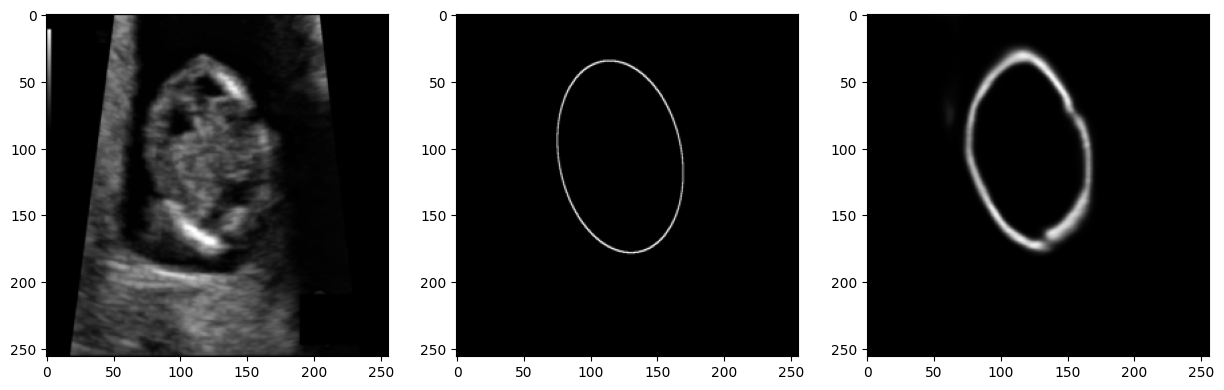

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


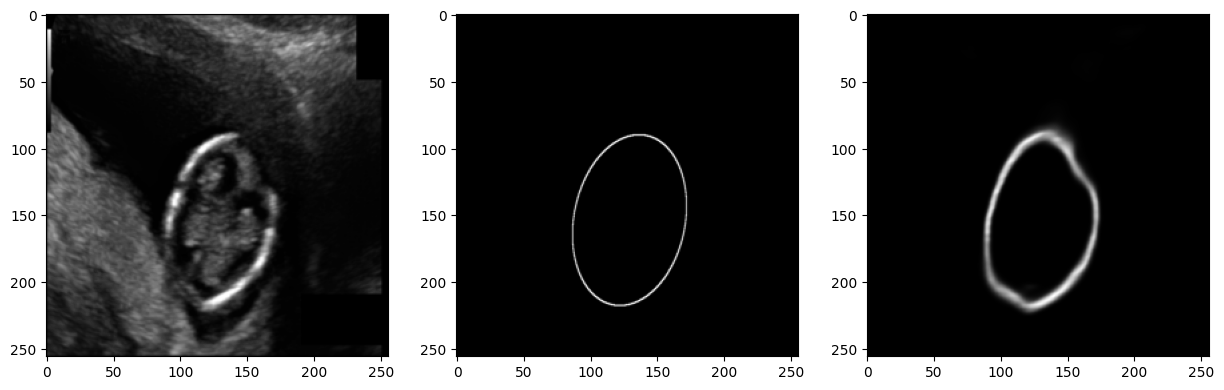

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


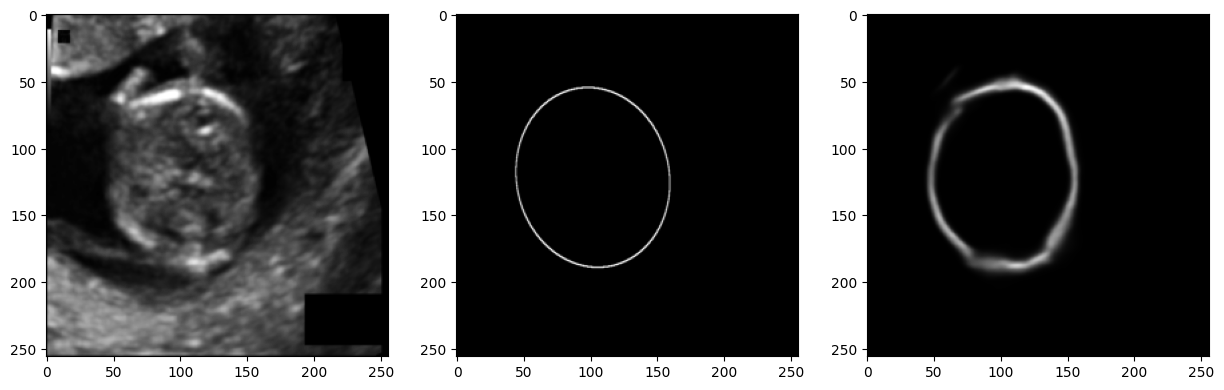

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


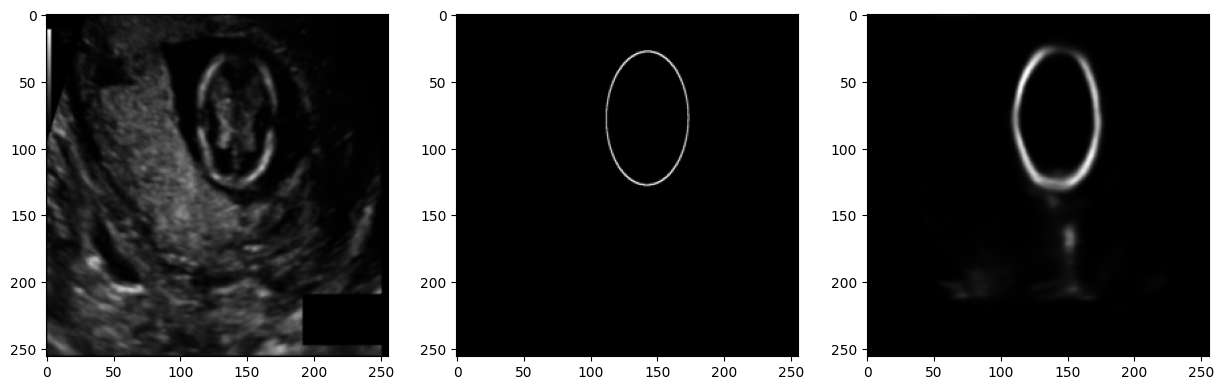

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [59]:
image_idx = 10
for image_idx in range(50, 60):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model(image.cuda().unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=1).to(device)
# Now use IoU as the loss function
criterion = CombinedLoss(alpha=0.85)
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_train, loss_valid = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=10)

100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 1/10 - Loss: 0.8338771855356681
Validation Loss: 0.18064714789390565


100%|██████████| 201/201 [00:44<00:00,  4.48it/s]


Epoch 2/10 - Loss: 0.1815151860613135
Validation Loss: 0.18033312797546386


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 3/10 - Loss: 0.18061926464239755
Validation Loss: 0.18189581215381623


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


Epoch 4/10 - Loss: 0.17874102531677455
Validation Loss: 0.17654470026493072


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


Epoch 5/10 - Loss: 0.17570041327630703
Validation Loss: 0.17301876664161683


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


Epoch 6/10 - Loss: 0.17270681039610905
Validation Loss: 0.17205542862415313


100%|██████████| 201/201 [00:45<00:00,  4.45it/s]


Epoch 7/10 - Loss: 0.17197409576147943
Validation Loss: 0.17188441395759582


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


Epoch 8/10 - Loss: 0.17144428756996175
Validation Loss: 0.17087278366088868


100%|██████████| 201/201 [00:45<00:00,  4.46it/s]


Epoch 9/10 - Loss: 0.1709292729695638
Validation Loss: 0.1709827572107315


100%|██████████| 201/201 [00:45<00:00,  4.47it/s]


Epoch 10/10 - Loss: 0.1706557701624448
Validation Loss: 0.1716981029510498


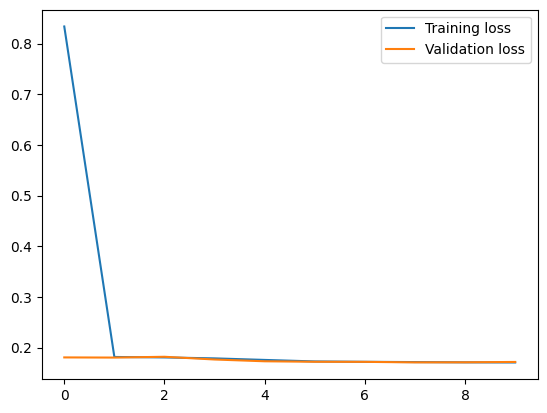

In [57]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training loss')
plt.plot(loss_valid, label='Validation loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'model.pth')


In [58]:
# Make predictions on the test set and use MAE as evaluation metric
from sklearn.metrics import mean_absolute_error

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"Mean Absolute Error: {mae}")
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou = iou_score(y_true, y_pred)
print(f"IoU: {iou}")


Mean Absolute Error: 10.364051818847656
IoU: 0.022345803000710228


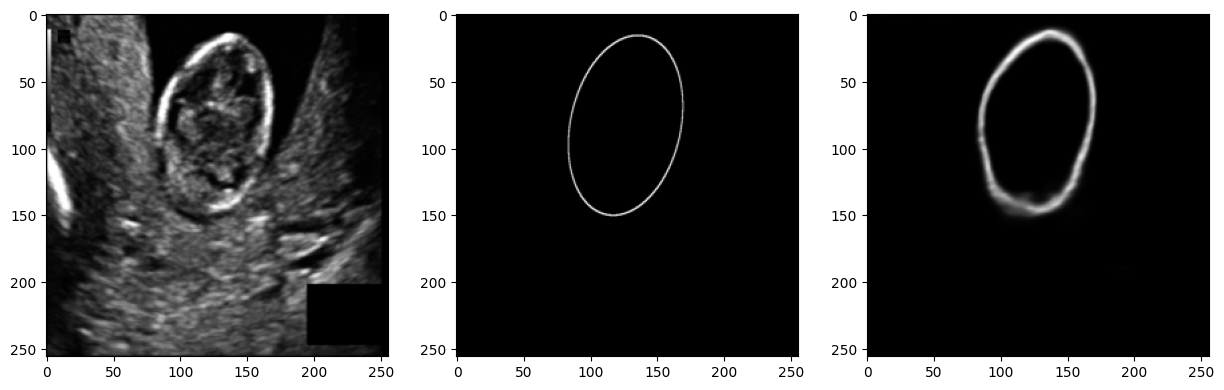

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


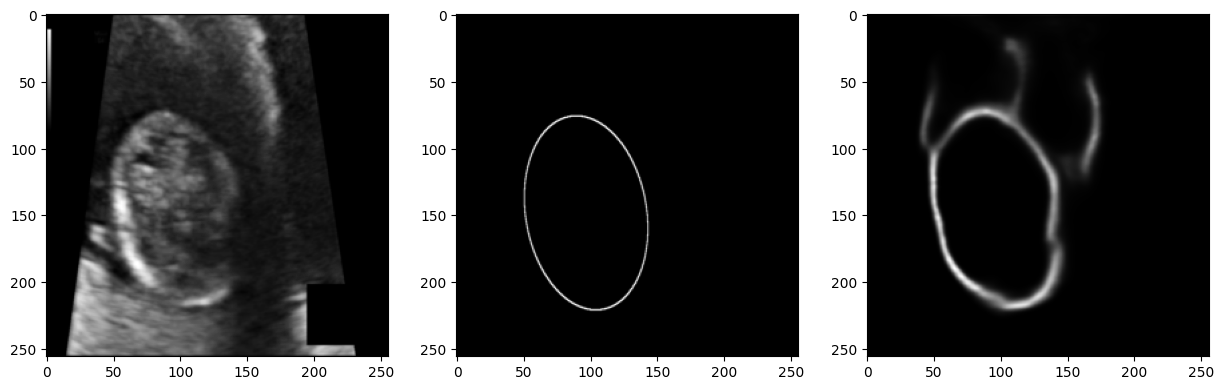

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


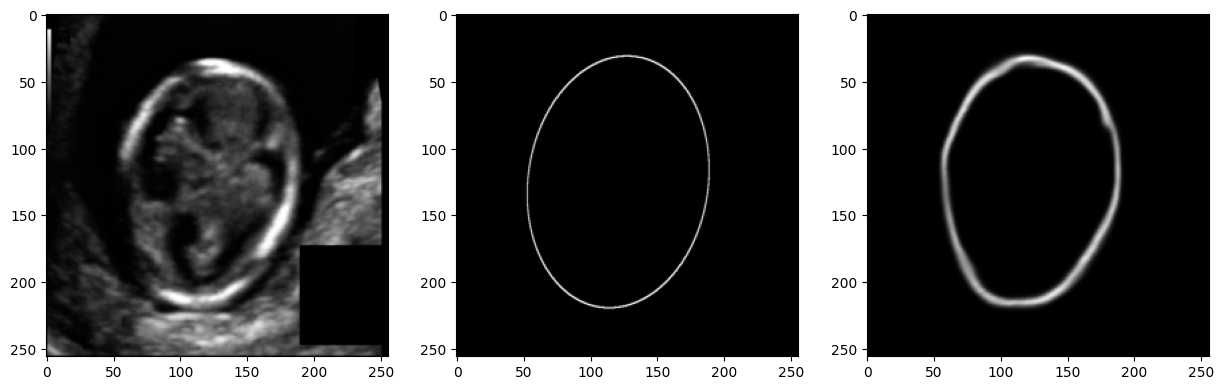

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


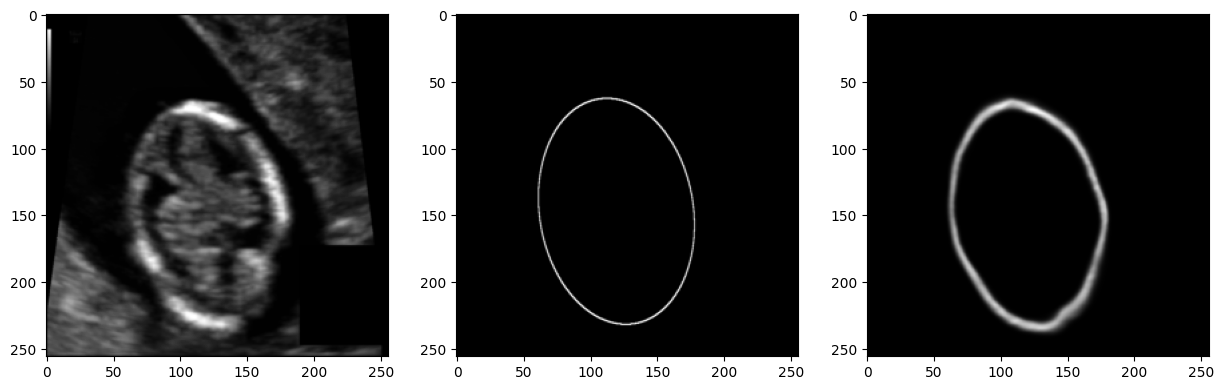

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


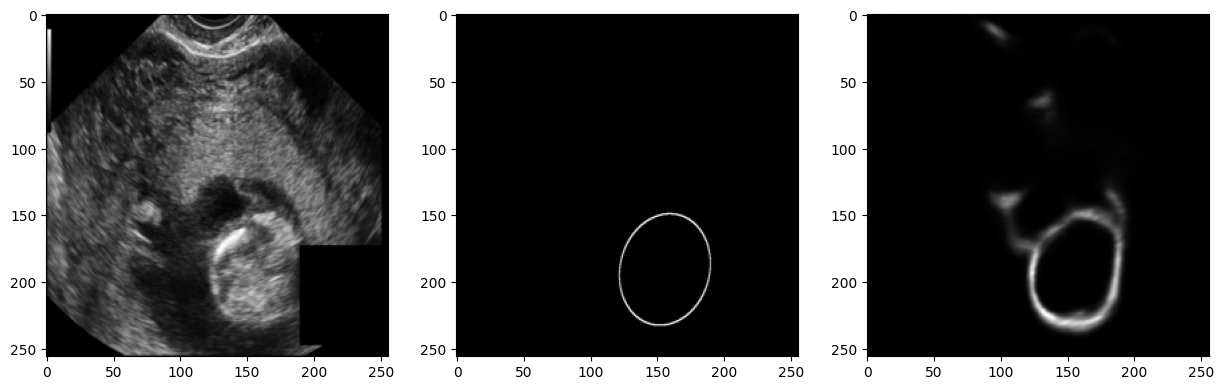

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


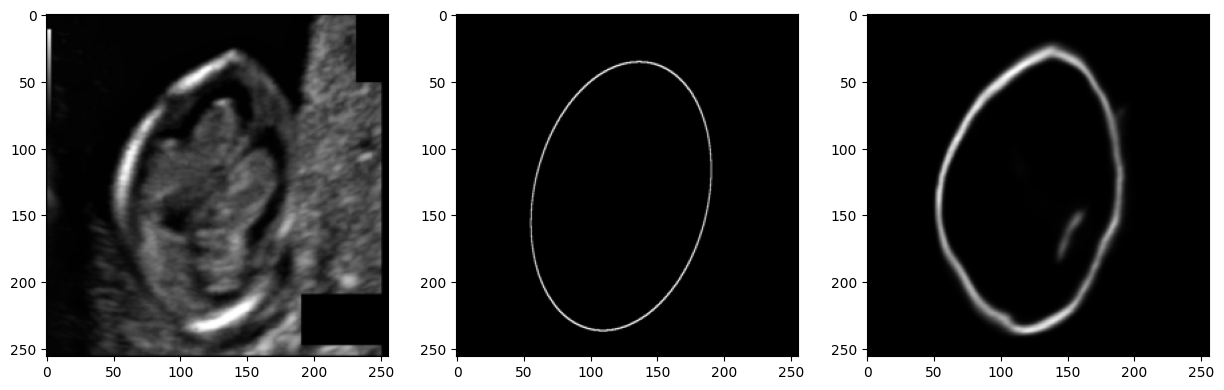

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


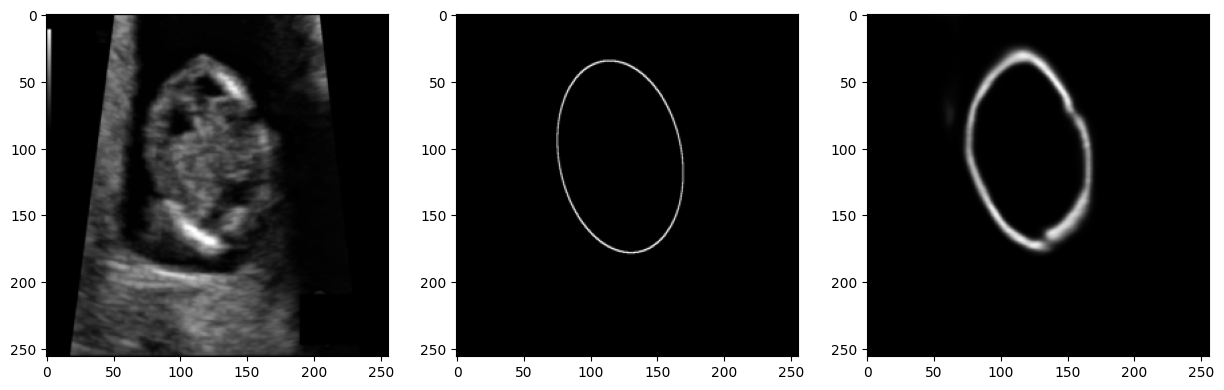

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


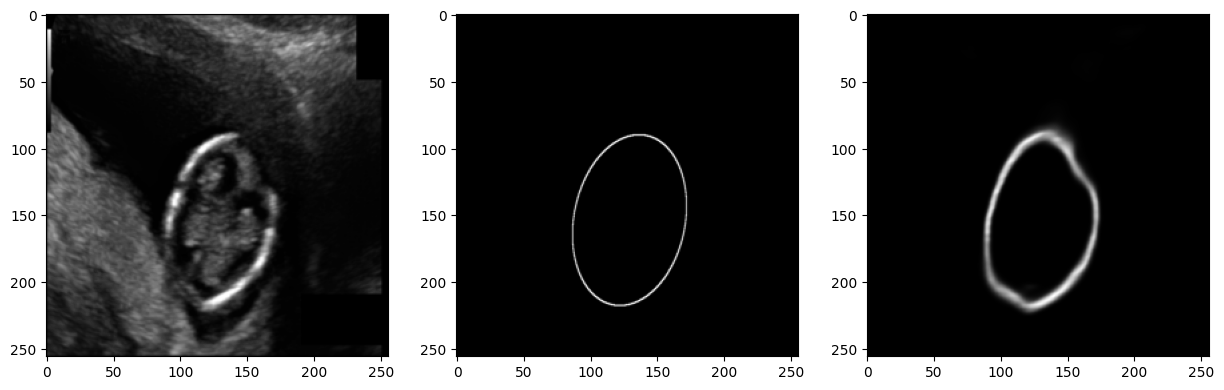

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


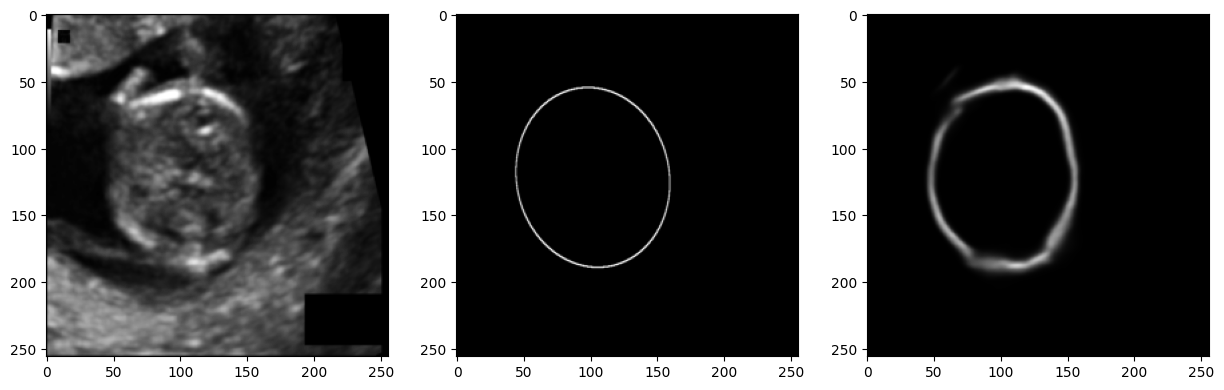

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


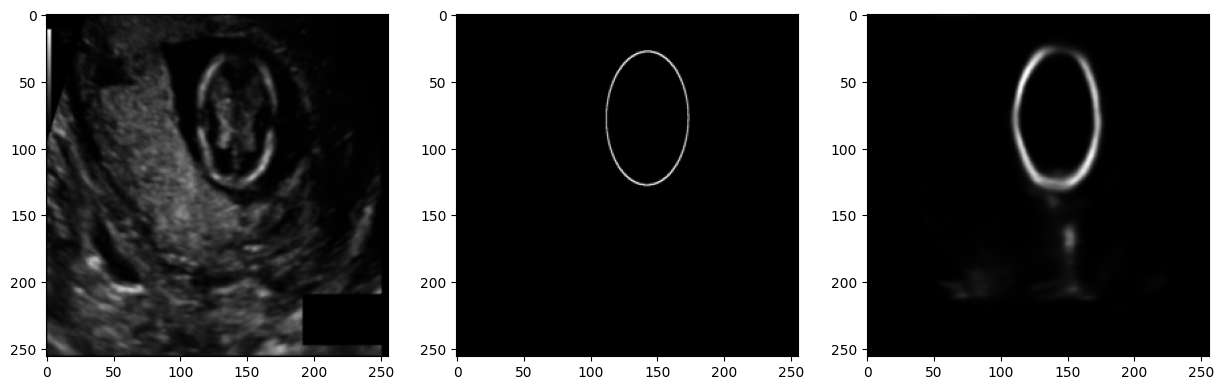

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [60]:
image_idx = 10
for image_idx in range(50, 60):
    image = train_dataset[image_idx][0]
    image_infer = train_dataset[image_idx][1]
    output = model(image.cuda().unsqueeze(0))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    axs[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ultrasound Image")
    axs[1].imshow(np.transpose(image_infer.cpu().numpy(), (1, 2, 0)), cmap = "gray", label = "Ground Truth Mask")
    axs[2].imshow(np.transpose(torch.sigmoid(output.squeeze(0)).cpu().detach().numpy(), (1, 2, 0)), cmap = "gray", label = "Predicted Mask")

    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
